# Exposure to drought


A simple accepted measure for drought is the Standardized Precipitation Index (SPI). Similar to indicators 1.1 and 1.2, this indicator is not a direct measure of health impacts of drought, but rather a measure of the risk factor, which is mediated by a range of complicated causes to health. In general, the claim is that increase in this indicator represents an increased risk, which may lead directly to negative impacts on health or require adaptation measures to mitigate negative impacts.

# TODO finalise threshold selection, betwen McKEy and Agnew and others

Agnew, C.T., Using the SPI to identify drought propose SPI thresholds:

| SPI      | Category         |
|----------|------------------|
| >= -0.84 | Normal           | 
| < -0.84  | Moderate Drought |
| < -1.28  | Severe drought   | 
| < -1.65  | Extreme drought  |



Select the locations experiencing 'Severe' drought on the 3-month basis. Define the drought indicator as 'number of months in drought' for a given year.



## Literature on selection of drought index

In 2009, the World Meteorological Organization (WMO) approved the Lincoln Declaration on Drought Indices (LDDI). The LDDI recommends that "the Standardized Precipitation Index (SPI) be used to characterize the meteorological droughts around the world", in addition to other drought indices that were in use in their service. In support of this recommendation, it was suggested that a "comprehensive user manual" describing the SPI should be developed. The manual provides a description of the index, the computation methods, specific examples of where it is currently being used, the strengths and limitations and mapping capabilities.

https://www.ncl.ucar.edu/Applications/spi.shtml

https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi


Note this one also good for extreme rain

https://link.springer.com/chapter/10.1007/978-94-015-9265-9_2

## SPI and SPEI drought inde
# TODO choose the right number of months for the index (6 or 12 probably see WMO document)
## TODO Pearson or Gamma variant?

> IMPORTANT: indication from publication (see other doc) that SPI and SPEI diverge due to temperatures. Looking at results the divergance is significant globally! This has implications on both the Lancet results directly and more generally on the use of SPI vs SPEI as an indicator of global prevalence of drought

>TODO formula

Python code:

https://www.drought.gov/drought/python-climate-indices


Also an implementation in NCL
https://www.ncl.ucar.edu/Applications/spi.shtml

Could apply directly to source files

https://www.ncl.ucar.edu/Document/Functions/Built-in/dim_spi_n.shtml


> NOTE the implementation from drought.gov looks modern and good (built with Numba, which suggests they know what they are doing and like modern approaches which should make life easier). Should be able to run directly on netCDF files from ECMWF.


## Data for SPI

Monthly summary data for PPT

NOTE that I have already a  National Center for Atmospheric Research (NCAR) 1949-2012 summary of SPI (https://rda.ucar.edu/datasets/ds298.0/). Do I really need to build my own? The main advantage is to ensure coherance across indicators and that they can be easily updated.

Can also use PPT data from CRU https://crudata.uea.ac.uk/cru/data/hrg/ http://data.ceda.ac.uk//badc/cru/data/cru_ts/cru_ts_4.01/data/ which covers a much longer time period than ECMFW ERA Interim (but only at monthly scale, which is not enough for heatwaves and i think labour). This is the data that was used to generate the NCAR dataset - could re-do it, should be possible using NCL directly


## Weighting indicator by population and by area

Initial calculation just did a drought count, but this ignores the relative size of the grid squares. A better approach could be to follow https://www.nature.com/articles/s41598-017-14283-2 with 'area in drought' (would need to calculate the real rather than relative size of grid squares).

The question is then how to calculate the population impacted? One possibility is to simply calculate the number of people. This would NOT be directly comparable to the area in drought however. It would only be able to show the relative trends.


In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook


import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [2]:
PPT_FOLDER = WEATHER_SRC / 'ecmwf' / 'monthly_precipitation'
POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

In [3]:
spi6 = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi6_1901_2016_cru.nc')

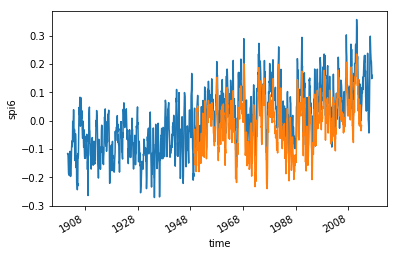

In [200]:
spi6.mean(dim=['lon','lat']).plot()
# spi.spi6.mean(dim=['lat', 'lon']).plot()

In [4]:
droughts = spi6.where(spi6 < -1.28)

In [5]:
drought_counts = droughts.groupby('time.year').count(dim='time').astype(float)

### Plot aboslute drought counts and drought exposures (not comparing to historical values)

- This might be better than historical comparison because SPI already fits a distribution to the historical data at every location, so calculating an anomaly vs the past is somewhat redundant

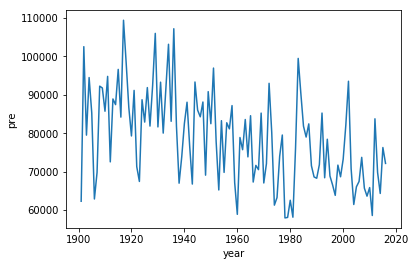

In [7]:
drought_counts.sum(dim=['lat', 'lon']).plot()

In [8]:
drought_count_projected = population_tools.project_to_population(drought_counts, end_year=2016, norm=False)

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

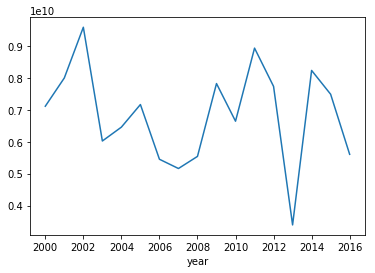

In [9]:
drought_count_projected.plot()

### Calculate change in drought counts and exposure relative to 1986-2008 mean

In [10]:
drought_counts_historical = drought_counts.sel(year=slice(1986,2008)).mean(dim='year')

In [11]:
drought_count_changes = drought_counts-drought_counts_historical

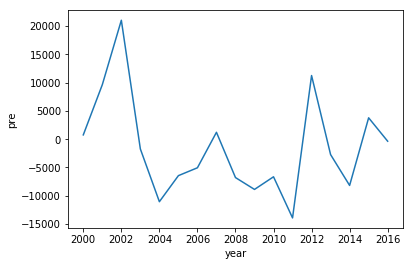

In [12]:
drought_count_changes.sel(year=slice(2000,2016)).sum(dim=['lat', 'lon']).plot()

In [13]:
drought_count_changes_projected = population_tools.project_to_population(drought_count_changes, end_year=2016)

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

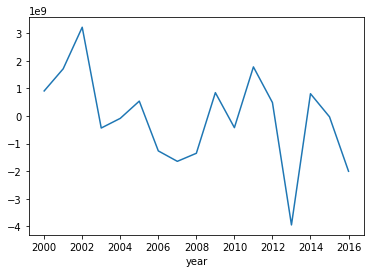

In [14]:
drought_count_changes_projected.plot()

# TODO MOVE THIS: heavy rain (taken as very high SPI values)

In [22]:
rain = spi6.where(spi6 > 1.28)

In [23]:
rain_counts = rain.groupby('time.year').count(dim='time').astype(float)

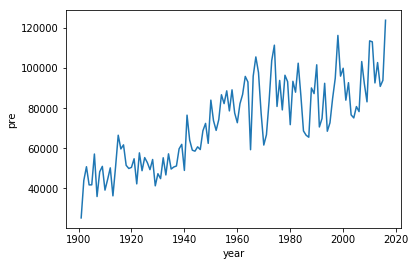

In [24]:
rain_counts.sum(dim=['lat', 'lon']).plot()

# Plot droughts identified using SPEI instead of SPI

### Use SPEI 6 for now

# TODO thresholds for SPEI

https://www.sciencedirect.com/science/article/pii/S0022169414010221

M. Svoboda, D. LeComte, M. Hayes, R. Heim, K. Gleason, J. Angel, B. Rippey, R. Tinker, M. Palecki, D. Stooksbury, D. Miskus, S. Stephens
The drought monitor
Bull. Am. Meteorol. Soc., 83 (2002), pp. 1181-1190

In [15]:
spei6 = xr.open_dataarray(DATA_SRC / 'lancet' / 'spei6_1901_2016_cru.nc')

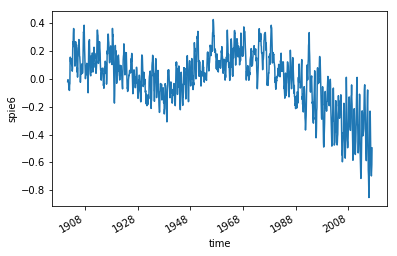

In [16]:
spei6.mean(dim=['lon','lat']).plot()

In [17]:
droughts_spei = spei6.where(spei6 < -1.28)

In [18]:
droughts_spei_counts = droughts_spei.groupby('time.year').count(dim='time').astype(float)

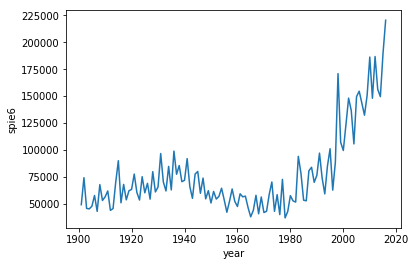

In [19]:
droughts_spei_counts.sum(dim=['lat', 'lon']).plot()

In [20]:
droughts_spei_count_projected = population_tools.project_to_population(droughts_spei_counts, end_year=2016, norm=False)

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

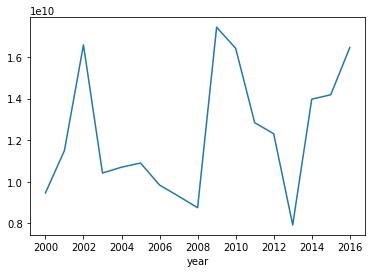

In [21]:
droughts_spei_count_projected.plot()